# Optimization by DR

## import and definitions

In [1]:
import sys
sys.path.append('/Users/ik/Desktop/zepeto')
from a_python.rigging_class.rig_hier_maya_torch import *
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle as pkl
import scipy
import torch
import math
import time
import pytorch3d
from a_python.utils.rot import _rot_base

from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    OpenGLOrthographicCameras,
    FoVPerspectiveCameras, 
    PointLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader
)
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer.mesh.rasterize_meshes import rasterize_meshes_python

from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer.blending import sigmoid_alpha_blend, _sigmoid_alpha



def img_upperbody_maya_joints(keypts):
    '''maya관절 길이비율대로 상체 조인트 추가 : chest upper, chest, spine'''
    img_hip = (keypts[9,:2] + keypts[12,:2])/2
    img_neck = (keypts[2,:2] + keypts[5,:2])/2
    img_spine = (img_neck - img_hip) * len_joint_upper[-1] + img_hip
    img_chest = (img_neck - img_hip) * (len_joint_upper[-1] + len_joint_upper[-2]) + img_hip
    img_chsetupper = (img_neck - img_hip) * (len_joint_upper[-1] + len_joint_upper[-2] + len_joint_upper[-3])  + img_hip
    return img_hip, img_neck, img_spine, img_chest, img_chsetupper

def fitting_based_on_upperbody_joints(body, img_spine, img_hip, img_neck, _vertices):
    '''img_upperbody_maya_joints 함수 결과 사용해서 메쉬 스케일링으로 상체 조인트위치 맞춤'''
    # hip to spine 거리
    _len_spine_maya = np.linalg.norm(body.head - body.childs[0].head) 
    _len_spine_img = np.linalg.norm(img_spine - img_hip)

    # 상체 조인트 맞춤
    _spine_trans = -(_len_spine_maya - _len_spine_img) * \
        ((-body.head + body.childs[0].head) / np.linalg.norm(body.head - body.childs[0].head))
    body.childs[0].trans_head(_spine_trans, _vertices)
    _scale_spine_hier = (np.linalg.norm(img_hip - img_neck) * len_joint_upper[-1]) / \
        (np.linalg.norm(body.childs[0].head - body.childs[0].childs[0].head))
    body.childs[0].scale_iso_hier(_scale_spine_hier, _vertices)

def _rot_base(axis, angle):
    zero = torch.zeros_like(angle)
    one = torch.ones_like(angle)
    if axis == 'x':
        return torch.tensor(
            [
                torch.stack([one, zero, zero]),
                torch.stack([0, torch.cos(angle), -torch.sin(angle)]),
                torch.stack([0, torch.sin(angle), torch.cos(angle)])
            ]
        )

    if axis == 'y':
        return torch.tensor(
            [
                torch.stack([torch.cos(angle), zero, torch.sin(angle)]),
                torch.stack([zero, one, zero]),
                torch.stack([-torch.sin(angle), zero, torch.cos(angle)])
            ]
        )

    if axis == 'z':
        return torch.stack(
            [
                torch.stack([torch.cos(angle), -torch.sin(angle), zero]),
                torch.stack([torch.sin(angle), torch.cos(angle), zero]),
                torch.stack([zero, zero, one]),
            ]
        )

def deform_mesh(opt_x, body, _vertices_opt):
    body.childs[1].childs[0].scale_y(opt_x[2], _vertices_opt)
    body.childs[1].childs[0].scale_z(opt_x[2], _vertices_opt)
    body.childs[1].childs[0].childs[0].scale_y(opt_x[3], _vertices_opt)
    body.childs[1].childs[0].childs[0].scale_z(opt_x[3], _vertices_opt)
    
    body.childs[1].childs[1].scale_y(opt_x[2], _vertices_opt)
    body.childs[1].childs[1].scale_z(opt_x[2], _vertices_opt)
    body.childs[1].childs[1].childs[0].scale_y(opt_x[3], _vertices_opt)
    body.childs[1].childs[1].childs[0].scale_z(opt_x[3], _vertices_opt)

    body.childs[1].childs[0].rot(_rot_base('z', opt_x[0]), _vertices_opt, inplace=False)
    body.childs[1].childs[1].rot(_rot_base('z', opt_x[1]), _vertices_opt, inplace=False)

def render_changed_mesh_subimg(body, mesh, _vertices, opt_x, img_size, rasterize_size, crotch_subimg):
    # mesh change
    _vertices_opt = copy.deepcopy(_vertices)
    body_copy = copy.deepcopy(body)
    deform_mesh(opt_x, body_copy, _vertices_opt)

    move = torch.tensor([rasterize_size/2, rasterize_size/2, 0]) - crotch_subimg

    # 허벅지 crop에 맞게 cropped rasterize
    mesh._verts_packed = (
        _vertices_opt - _vertices_opt[3106,:]\
        + torch.tensor([0, 0, img_size/2]) + move
        ) / (rasterize_size / 2)
    
    fragments = rasterize_meshes(mesh, image_size = rasterize_size, blur_radius=0, faces_per_pixel=8, perspective_correct= False, )
    blend_params = BlendParams()
    res = _sigmoid_alpha(fragments[3], fragments[0], blend_params.sigma)
    return res

def loss_dr(img_target, opt_x, body, _vertices, crotch, crotch_subimg, img_size,rasterize_size, mesh, img_weight = None):
    res = render_changed_mesh_subimg(body, mesh, _vertices, opt_x, img_size, rasterize_size, crotch_subimg)

    # 넘치는거 막기 위한 가중치 있을 떄
    if img_weight is None:
        loss = (torch.abs(img_target - res)).sum()
    else:
        loss = (img_weight * torch.abs(img_target - res)).sum()
    
    return loss



## basic settings

In [2]:
# 사진 index

idx_img = 11
idx_img = 8

# optimize parameters
n_iter = 50
alpha_loss_excede_mask = 10          # 마스크 넘어가는거에 얼마나 가중치 줄건지

visualize_pcd = False


scales: tensor(2.5097) , tensor(0.8982) , tensor(0.9761) , tensor(0.8403)
1.2979199886322021


/opt/homebrew/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


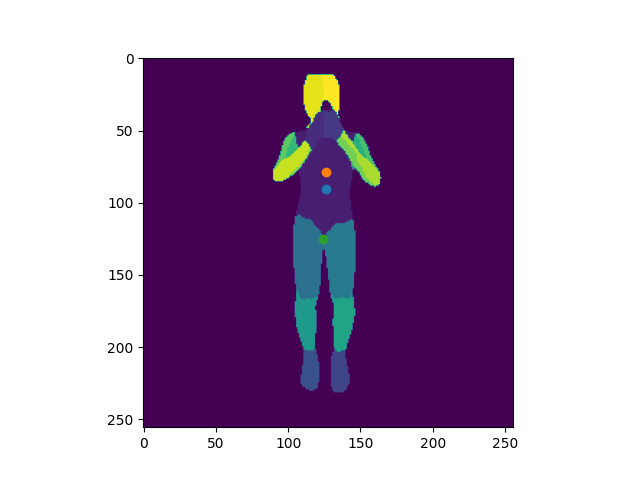

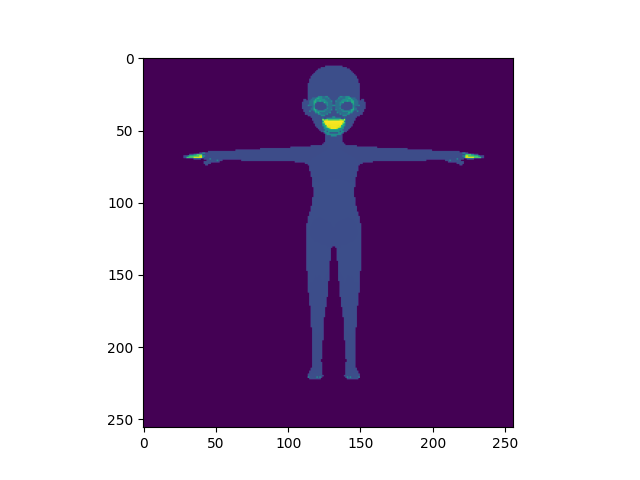

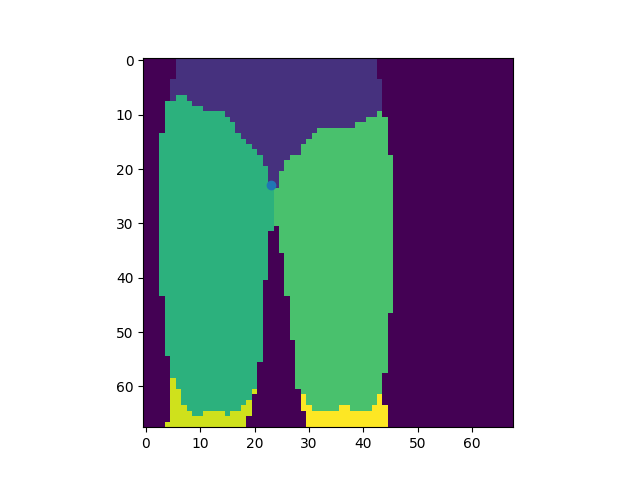

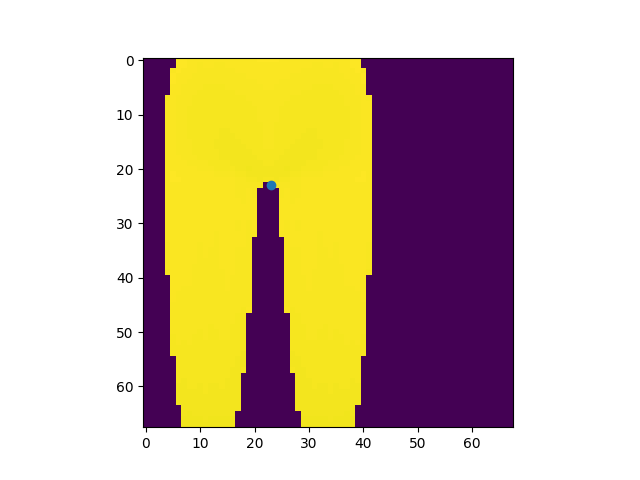

In [3]:
time_start = time.time()
folder = idx_img
path_img = "/Users/ik/Downloads/test_set_new/{}/test_resized.png".format(folder)
path_json = "/Users/ik/Downloads/test_set_new/{}/test_resized_keypoints.json".format(folder)
path_dp = "/Users/ik/Downloads/test_set_new/{}/dp_dump.pkl".format(folder)

with open(path_json, 'r') as f:
    data = json.load(f)
with open(path_dp, 'rb') as f:
    [img_seg, img_v, img_u,_] = pkl.load(f)
h,w = img_seg.shape
keypts = torch.tensor(data['people'][0]['pose_keypoints_2d']).reshape([-1,3])
img = cv.imread(path_img)

%matplotlib widget


body = rig_class(65)


h, w = img_seg.shape
x = np.linspace(0, w-1, w)
y = np.linspace(0, h-1, h)
xx, yy = np.meshgrid(x,y, indexing='xy')
x = torch.linspace(0, w-1, w)
y = torch.linspace(0, h-1, h)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

_vertices = copy.deepcopy(vertices)
# 가랑이 찾고, 하체 다리길이 맞추기용 키포인트 길이 구하기 : 가랑이부분 허벅지 두께, 무릎, 발목 폭
# image랑 _vertices의 스케일이 같아짐 
crotch = body.scaling_joint_len(_vertices, keypts, img_seg)

# 길이비율로 상체 오픈포즈에 마야 조인트 추가, 메쉬 맞추기
img_hip, img_neck, img_spine, img_chest, img_chsetupper = img_upperbody_maya_joints(keypts)
fitting_based_on_upperbody_joints(body, img_spine, img_hip, img_neck, _vertices)

# base mesh for face index
mesh = load_objs_as_meshes(['/Users/ik/Desktop/zepeto/blender/wip_find_weight.obj'], device)

img_size = h

# 사이즈 잘 맞춰줬나 확인
if True:
    # rasterization의 경우 normalize 해줘야함 [-1,1]
    mesh._verts_list[0] = (
        _vertices - _vertices[3106,:] + torch.tensor([crotch[0], crotch[1], 0]) \
        - torch.tensor([img_size/2, img_size/2, -img_size/2])
        )/img_size * 2

    tmp_scale = torch.tensor([1.0])
    tmp_scale.requires_grad = True
    mesh._verts_list[0] *= tmp_scale
    
    pre =time.time()

    fragments = rasterize_meshes(mesh, image_size = img_size, blur_radius=0, faces_per_pixel=8,\
        perspective_correct= False, )

    print(time.time() - pre)

    plt.figure('check size aligning : img_seg')
    plt.imshow(img_seg)
    plt.scatter(img_chest[0], img_chest[1])
    plt.scatter(img_chsetupper[0], img_chsetupper[1])
    plt.scatter(crotch[0], crotch[1])
    plt.figure('check size aligning : rasterize with only length matching')
    plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))



# body class 카피 - optimization에서 사용
body_init = copy.deepcopy(body)

img_mask = (img_seg!=0).astype(int)

# 허벅지 부분 이미지
thr_surplus = 3     # bouning box 여유분
mask_leg = (img_seg == 10) + (img_seg == 9)
bbox = np.array([[xx[mask_leg].min()-thr_surplus , yy[mask_leg].min()-thr_surplus],[xx[mask_leg].max()+thr_surplus , yy[mask_leg].max()+thr_surplus]]).astype(int)
_ul, _lr = torch.max(torch.abs(torch.from_numpy(bbox) - crotch), dim=1).values

rasterize_size = _ul+_lr

bbox = np.array([[crotch[0] - _ul, crotch[1] - _ul],[crotch[0] + _lr, crotch[1] + _lr]]).astype(int)
crotch_subimg = torch.tensor([_ul, _ul, 0])


# initial rasterization and subimage aligning
_vertices_opt = copy.deepcopy(_vertices)
## 허벅지 crop에 맞게 cropped rasterize
mesh_crotch = (
    _vertices_opt[3106,:] - _vertices_opt[3106,:] \
    - torch.tensor([crotch[0], crotch[1], 0]) \
    + torch.tensor([img_size/2, img_size/2, img_size/2])
    )/img_size * 2
mesh_crotch = mesh_crotch.detach()

# _mesh_scale = img_size / rasterize_size
# _move_x = 2*_ul/(_ul + _lr) - 1 - _mesh_scale * mesh_crotch[0] 
# _move_y = 2*_ul/(_ul + _lr) - 1 - _mesh_scale * mesh_crotch[1]

move = torch.tensor([rasterize_size/2, rasterize_size/2, 0]) - crotch_subimg



mesh._verts_packed = (
    _vertices_opt - _vertices_opt[3106,:]\
    + torch.tensor([0, 0, img_size/2]) + move
    ) / (rasterize_size / 2)

fragments = rasterize_meshes(mesh, image_size = _ul + _lr, blur_radius=0, faces_per_pixel=8, perspective_correct= False, )


if True:
    plt.figure('subimg')
    plt.imshow(img_seg[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]])
    plt.scatter(crotch_subimg[0],crotch_subimg[1])

    plt.figure('rasterize_base')
    plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))
    plt.scatter(crotch_subimg[0],crotch_subimg[1])


In [4]:
opt_x = torch.nn.Parameter(torch.tensor([0.,0.,1.,1.,1.,1., 0., 0.]))
'''opt_x : uppperlegtrans_x, uppperlegtrans_y, upperlegscale, uppertwistscale, scale_iso_upper, scale_iso_upper_twist, move_x, move_y'''

## rasterize 관련
colors = torch.ones_like(fragments[2])
## GT : 허벅지 부분 이미지
img_mask = (img_seg!=0).astype(int)
thr_surplus = 3
mask_leg = (img_seg == 10) + (img_seg == 9)
bbox = np.array([[xx[mask_leg].min()-thr_surplus , yy[mask_leg].min()-thr_surplus],[xx[mask_leg].max()+thr_surplus , yy[mask_leg].max()+thr_surplus]]).astype(int)
_ul, _lr = torch.max(torch.abs(torch.from_numpy(bbox) - crotch), dim=1).values
bbox = np.array([[crotch[0] - _ul, crotch[1] - _ul],[crotch[0] + _lr, crotch[1] + _lr]]).astype(int)
crotch_subimg = torch.tensor([_ul, _ul, 0])
img_target = torch.from_numpy((img_seg[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]]>0).astype(int))
tmp_img_weight = (img_seg[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]]>0).astype(int)
img_weight = torch.from_numpy((tmp_img_weight - 1) * (-alpha_loss_excede_mask) + tmp_img_weight)

## opitmize

In [5]:
torch.autograd.set_detect_anomaly(True)
opt_x = torch.nn.Parameter(torch.tensor([0.,0.,1.,1.,1.,1., 0., 0.]))

optimizer = torch.optim.SGD([{'params' : opt_x}], lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([{'params' : opt_x}], lr=0.01)


loss_all = []
result_opt_x = []


for i in range(n_iter):
    optimizer.zero_grad()
    loss = loss_dr(img_target, opt_x, body, _vertices, crotch, crotch_subimg, img_size,rasterize_size, mesh, img_weight)
    # loss = loss_dr(img_target, opt_x, body_init, _vertices, crotch, img_size, _ul, _lr, mesh, mesh_crotch, img_weight)
    print('loss:', loss)
    loss_all.append(loss.detach())
    # print('opt_x:', opt_x)
    # _result_opt_x = copy.deepcopy(opt_x)
    # result_opt_x.append(np.asarray(_result_opt_x.detach()))

    loss.backward()
    optimizer.step()

loss: tensor(816.6481, grad_fn=<SumBackward0>)
loss: tensor(720.6385, grad_fn=<SumBackward0>)
loss: tensor(641.1856, grad_fn=<SumBackward0>)
loss: tensor(651.8213, grad_fn=<SumBackward0>)
loss: tensor(641.4119, grad_fn=<SumBackward0>)
loss: tensor(613.0660, grad_fn=<SumBackward0>)
loss: tensor(594.5946, grad_fn=<SumBackward0>)
loss: tensor(579.8469, grad_fn=<SumBackward0>)
loss: tensor(575.2359, grad_fn=<SumBackward0>)
loss: tensor(559.7493, grad_fn=<SumBackward0>)
loss: tensor(556.1882, grad_fn=<SumBackward0>)
loss: tensor(551.2543, grad_fn=<SumBackward0>)
loss: tensor(553.3882, grad_fn=<SumBackward0>)
loss: tensor(555.5899, grad_fn=<SumBackward0>)
loss: tensor(548.4608, grad_fn=<SumBackward0>)
loss: tensor(527.7053, grad_fn=<SumBackward0>)
loss: tensor(505.6339, grad_fn=<SumBackward0>)
loss: tensor(488.4312, grad_fn=<SumBackward0>)
loss: tensor(477.9198, grad_fn=<SumBackward0>)
loss: tensor(453.8575, grad_fn=<SumBackward0>)
loss: tensor(507.3789, grad_fn=<SumBackward0>)
loss: tensor(

## result visualize

### plot

time_all :  24.36803102493286
opt_x:  Parameter containing:
tensor([-0.0155, -0.0679,  1.1911,  1.2980,  1.0000,  1.0000,  0.0000,  0.0000],
       requires_grad=True)


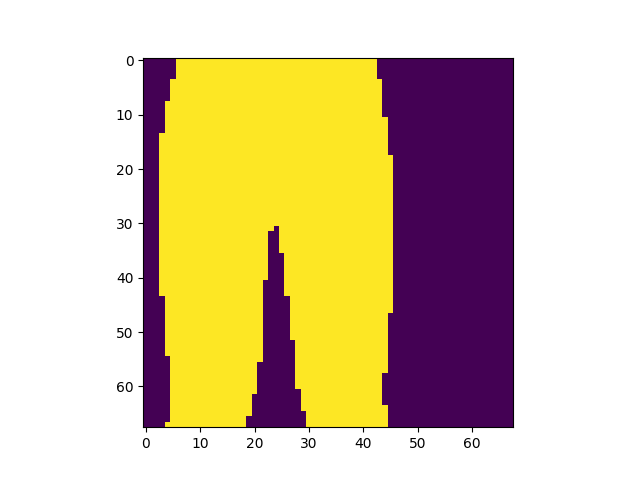

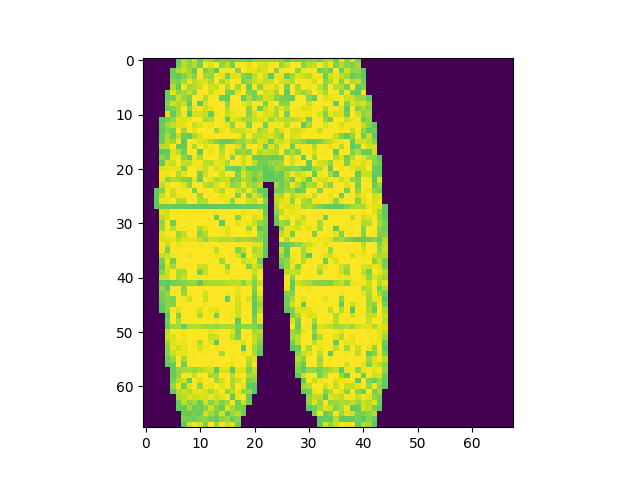

In [6]:
%matplotlib widget
print("time_all : ", time.time() - time_start)
print("opt_x: ", opt_x)
# opt_x = torch.nn.Parameter(torch.tensor([0.,0.,1.,1.,1.,1., 0., 0.]))
res = render_changed_mesh_subimg(body, mesh, _vertices, opt_x, img_size, rasterize_size, crotch_subimg)

plt.figure('GT')
plt.imshow(img_target)
plt.figure('optimization_result')
plt.imshow(np.asarray(res[0].detach()))


### pointcloud

In [7]:
if visualize_pcd:
    _list_joint = []
    pcd = o3d.geometry.PointCloud()

    _vertices_opt = copy.deepcopy(_vertices)
    body_copy = copy.deepcopy(body_init)
    deform_mesh(opt_x, body_copy, _vertices_opt)


    _vertices_draw = np.asarray(copy.deepcopy(_vertices_opt.detach()))

    # _vertices_draw = np.asarray(copy.deepcopy(_vertices.detach()))
    pcd.points = o3d.utility.Vector3dVector(_vertices_draw)
    _color = np.ones([9067,3])*np.array([0.5,0.3,1])
    pcd.colors = o3d.utility.Vector3dVector(_color)
    # _pcd = o3d.geometry.PointCloud()
    # _pcd.points = o3d.utility.Vector3dVector(vertices)
    # _list_joint.append(_pcd)
    _list_joint.append(pcd)
    body.draw_joint(_list_joint)
    o3d.visualization.draw_geometries(_list_joint)




# wip